<a href="https://colab.research.google.com/github/alexandrgsv/stock_prediction_models/blob/main/MMVB_ga_ub_lb_ipynb_weights_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

In [35]:
import tensorflow as tf
import math
tf.executing_eagerly()

True

In [36]:
# Load the data
#data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D', header=0, usecols=['<DATE>', '<CLOSE>'], date_parser=True)
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D',
                   header=0,
                   usecols=['<DATE>', '<CLOSE>'],
                   parse_dates=['<DATE>'],
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%y'))

df = data[['<DATE>', '<CLOSE>']].copy()

In [37]:
df = df.sort_values('<DATE>')
df = df.reset_index(drop=True)
#df = df.set_index('<DATE>').sort_index()



In [38]:
def PICP(y_true, y_pred):

    n = tf.shape(y_pred)[0]
    c = tf.TensorArray(dtype=tf.float32, size=n)

    for i in tf.range(n):
        #print('i = ', i, ' ytrue[i] = ', y_true[i])
        #print('ypred[i][0] = ', y_pred[i][0])
        #print('ypred[i][1] = ', y_pred[i][1])
        if y_true[i] >= y_pred[i][0] and y_true[i] <= y_pred[i][1]:
            c = c.write(i, 1.0)
        else:
            #if y_true[i] > y_pred[i][1]:
            #  c = c.write(i, abs(y_true[i]-y_pred[i][1])/2500)
            #if y_true[i] < y_pred[i][0]:
            #  c = c.write(i, abs(y_pred[i][0]- y_true[i])/2500)
           c = c.write(i, 0.0)
    #print("PICP = ", tf.reduce_sum(c.stack()) / tf.cast(n, dtype=tf.float32))

    return tf.reduce_sum(c.stack()) / tf.cast(n, dtype=tf.float32)

In [39]:
def PINRW(y_pred, R = 1.00):
    n = tf.shape(y_pred)[0]
    sum_of_squared_diff = tf.reduce_sum(tf.square(y_pred[:, 1] - y_pred[:, 0]))
    #print("PINRW = ", tf.sqrt(sum_of_squared_diff / tf.cast(n, dtype=tf.float32)) / R)
    return tf.sqrt(sum_of_squared_diff / tf.cast(n, dtype=tf.float32)) / R


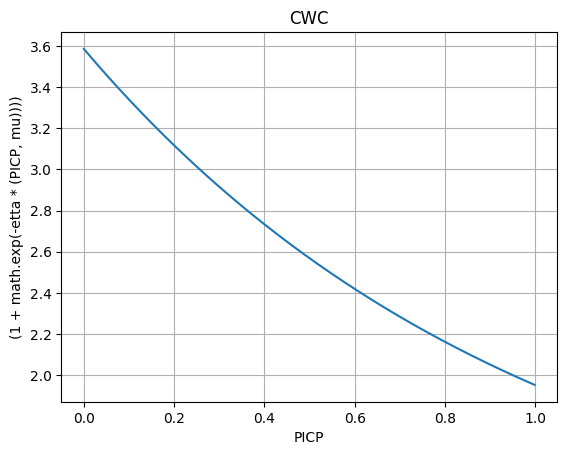

In [40]:
import matplotlib.pyplot as plt

etta = 1
mu = 0.95

x = np.arange(0.0, 1, 0.001)
y = (1 + np.exp(-etta * (x - mu)))

plt.plot(x, y)
plt.xlabel('PICP')
plt.ylabel('(1 + math.exp(-etta * (PICP, mu))))')
plt.title('CWC')
plt.grid(True)
plt.show()

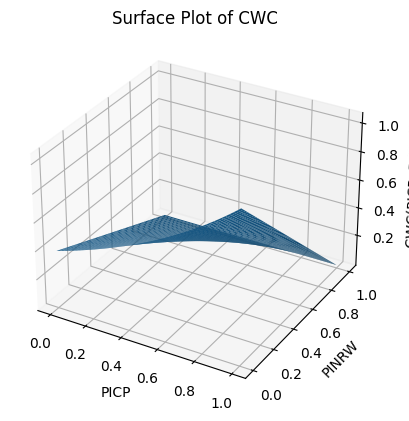

Maximum value of Z: 1.0502203507400283
Corresponding PICP and PINRW values: 0.999 0.0


In [41]:
from mpl_toolkits.mplot3d import Axes3D

etta = 1
mu = 0.95

x = np.arange(0, 1, 0.001)
y = np.arange(0, 1, 0.001)
X, Y = np.meshgrid(x, y)
Z = (1-Y) * (np.exp(etta * (X - mu)))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

ax.set_xlabel('PICP')
ax.set_ylabel('PINRW')
ax.set_zlabel('CWC(PICP, PINRW)')
ax.set_title('Surface Plot of CWC')

plt.show()

max_value = np.max(Z)
max_index = np.unravel_index(np.argmax(Z), Z.shape)
max_x = X[max_index]
max_y = Y[max_index]

print("Maximum value of Z:", max_value)
print("Corresponding PICP and PINRW values:", max_x, max_y)

In [42]:
def CWC(y_true, y_pred, etta = 1, mu = 0.95):
    #print("PICP = ", PICP(y_true, y_pred))
    #print("tf.exp = " , tf.exp(-etta * (tf.subtract(PICP(y_true, y_pred), mu))))
    #print("CWC = ", (1-PINRW(y_pred)) * (tf.exp(etta * (tf.subtract(PICP(y_true, y_pred), mu)))))
    return (1-PINRW(y_pred)) * (tf.exp(etta * (tf.subtract(PICP(y_true, y_pred), mu))))


In [43]:
df.tail()

,<DATE>,<CLOSE>
5005,2023-03-23,2388.35
5006,2023-03-24,2391.53
5007,2023-03-27,2440.68
5008,2023-03-28,2442.19
5009,2023-03-29,2444.90


In [44]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

In [45]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['<CLOSE>'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['<CLOSE>'].values.reshape(-1, 1))
#train_scaled = train['<CLOSE>'].values.reshape(-1, 1)
#test_scaled = test['<CLOSE>'].values.reshape(-1, 1)

In [46]:
X_test = test_scaled[:-1]
y_test = test_scaled[1:]

In [47]:
X_train = train_scaled[:-1]
y_train = train_scaled[1:]

In [48]:
X_train.shape

(4007, 1)

In [49]:
y_train.shape

(4007, 1)

In [50]:
X_test.shape

(1001, 1)

In [51]:
y_test.shape

(1001, 1)

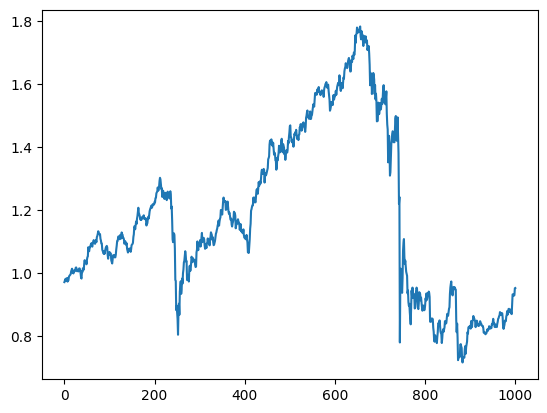

In [52]:
plt.plot(X_test)

In [53]:
from tensorflow.keras.metrics import mean_squared_error

def custom_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)


In [54]:
# Define the model
model = Sequential([
    #LSTM(units=50, input_shape = (None, 1), return_sequences = True),
    #LSTM(units=50, return_sequences = True),
    #LSTM(units=30),
    #Dense(units=6),
    #Dense(units=6),
    #Dense(units=6),
    #Dense(units=6),
    Dense(units=3),
    Dense(units=3),
    Dense(units=2)
])
#model.compile(optimizer=Adam(learning_rate=0.1), run_eagerly=True, loss=CWC)

# Build the model
input_shape = X_train.shape[1:]
model.build((None, *input_shape))


In [55]:
!pip install pygad

In [56]:
import pygad.kerasga

keras_ga = pygad.kerasga.KerasGA(model=model,
                                 num_solutions=5)

In [57]:
def fitness_func(self, solution, sol_idx):
    global X_train, y_train, keras_ga, model, max_value

    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                 weights_vector=solution)

    model.set_weights(weights=model_weights_matrix)

    predictions = model.predict(X_train)

    #solution_fitness = 1.0 / (CWC(y_train, predictions).numpy() + 0.00000001)
    solution_fitness = CWC(y_train, predictions).numpy() / max_value


    return solution_fitness

In [58]:
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [59]:
num_generations = 500
num_parents_mating = 3
initial_population = keras_ga.population_weights

#initial_population = [0.22093065, 0.58833356, -0.84820803, 0.23648918, -0.71320623, 0.2064331, -0.97116915, 1.04615182, 0.80727385, 0.47603647, 0.23161068, 0.13077368, -1.49202372, -0.4944429, -0.22464426, 0.25295741, 0.0, 0.17442633, 0.60633677, 0.51915963, 0.64211702, 1.3131730, -0.14896559, -1.97565626, 0.0624268, 0.99700325]

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       stop_criteria="saturate_60",
                       on_generation=callback_generation)

In [60]:
ga_instance.run()


126/126 [==============================] - 0s 1ms/step
Generation = 1
126/126 [==============================] - 0s 1ms/step
Fitness    = 0.37468611248427913
126/126 [==============================] - 0s 1ms/step
Generation = 2
126/126 [==============================] - 0s 1ms/step
Fitness    = 0.3784419496041003
126/126 [==============================] - 0s 1ms/step
Generation = 3
126/126 [==============================] - 0s 1ms/step
Fitness    = 0.5284638255494442
126/126 [==============================] - 0s 2ms/step
Generation = 4
126/126 [==============================] - 0s 1ms/step
Fitness    = 0.5284638255494442
126/126 [==============================] - 0s 1ms/step
Generation = 5
126/126 [==============================] - 0s 1ms/step
Fitness    = 0.5284638255494442
126/126 [==============================] - 0s 2ms/step
Generation = 6
126/126 [==============================] - 0s 1ms/step
Fitness    = 0.5284638255494442
126/126 [==============================] - 0s 1ms/step
Ge

In [61]:
# Train the model
#history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


In [62]:
display(test)

,<DATE>,<CLOSE>
4008,2019-03-18,2483.70
4009,2019-03-19,2493.28
4010,2019-03-20,2504.23
4011,2019-03-21,2507.81
4012,2019-03-22,2492.70
...,...,...
5005,2023-03-23,2388.35
5006,2023-03-24,2391.53
5007,2023-03-27,2440.68
5008,2023-03-28,2442.19


In [63]:
y_test.shape

(1001, 1)

In [64]:
y_train.shape

(4007, 1)

In [65]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()


126/126 [==============================] - 0s 2ms/step


In [66]:
model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                 weights_vector=solution)
model.set_weights(weights=model_weights_matrix)

In [67]:
#best weights

print("best weights = ", solution)

best weights =  [ 1.02901446 -1.21736876 -1.12265858  0.16970676 -0.15003721 -1.82765718
  0.39344537 -0.08058794 -0.16508483 -0.74179014  0.24441449 -1.30371831
 -0.39904412 -0.08856522  1.16909771 -0.60832883 -0.51306615  0.28443295
  0.69924734  0.04713451  0.48045363 -2.78891688 -0.06541059  0.383127
 -0.20235689 -0.41437334]


In [70]:
print("population = ", ga_instance.population)

population =  [[ 1.02901446 -1.21736876 -1.12265858  0.16970676 -0.15003721 -1.82765718
   0.39344537 -0.08058794 -0.16508483 -0.74179014  0.24441449 -1.30371831
  -0.39904412 -0.08856522  1.16909771 -0.60832883 -0.51306615  0.28443295
   0.69924734  0.04713451  0.48045363 -2.78891688 -0.06541059  0.383127
  -0.20235689 -0.41437334]
 [ 1.02901446 -1.21736876 -1.12265858  0.16970676 -0.15003721 -1.82765718
   0.39344537 -0.08058794 -0.16508483 -0.74179014  0.24441449 -1.30371831
  -0.39904412 -0.02981208  1.16909771 -0.1282633  -0.51306615 -0.00792849
   1.36856839  0.04713451  0.48045363 -2.78891688 -0.06541059  0.383127
  -0.20235689 -0.41437334]
 [ 0.86145026 -0.48755903 -1.0143346   0.16970676  0.15420954 -1.82765718
   0.80612125 -0.08058794 -0.16508483 -0.74179014  0.24441449 -1.30371831
  -0.39904412 -0.08856522  1.16909771 -0.1282633  -0.51306615  0.28443295
   0.69924734  0.97117789  0.48045363 -2.78891688 -0.06052364  0.39895126
  -0.20235689 -0.41437334]
 [ 1.02901446 -1.2173

In [71]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

32/32 [==============================] - 0s 1ms/step


In [72]:
y_pred.shape

(1001, 2)

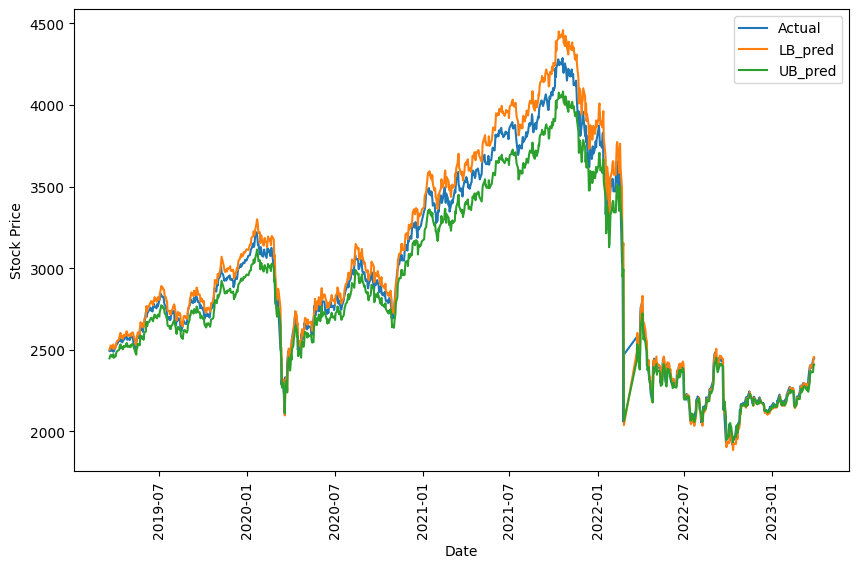

In [73]:
# Plot the actual and predicted stock prices with the upper and lower bounds
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test['<DATE>'][1:], y_test, label='Actual')


ax.plot(test['<DATE>'][1:], y_pred[:,0], label='LB_pred')
ax.plot(test['<DATE>'][1:], y_pred[:,1], label='UB_pred')

#ax.fill_between(test['<DATE>'], y_pred[:, 0][::forecast_horizon]-y_pred[:, 1][::forecast_horizon], y_pred[:, 0][::forecast_horizon]+y_pred[:, 2][::forecast_horizon], alpha=0.2, label='Bounds')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.xticks(rotation=90)
plt.show()